In [1]:
import pandas

In [2]:
data = pandas.read_csv('data/winequality-red.csv', sep=';')

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data.columns

Index([u'fixed acidity', u'volatile acidity', u'citric acid',
       u'residual sugar', u'chlorides', u'free sulfur dioxide',
       u'total sulfur dioxide', u'density', u'pH', u'sulphates', u'alcohol',
       u'quality'],
      dtype='object')

In [5]:
variables = [u'fixed acidity', u'volatile acidity', u'citric acid',
       u'residual sugar', u'chlorides', u'free sulfur dioxide',
       u'total sulfur dioxide', u'density', u'pH', u'sulphates', u'alcohol']

In [6]:
%matplotlib inline

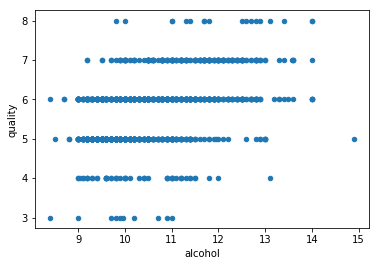

In [7]:
data.plot.scatter(x = 'alcohol', y = 'quality')

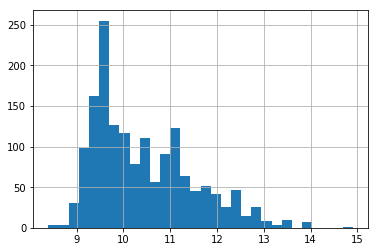

In [8]:
data.alcohol.hist(bins = 30)

## The numpy way

In [9]:
import numpy as np

In [10]:
X = data[variables].values

In [11]:
N, p = X.shape

In [12]:
N, p

(1599, 11)

In [13]:
# adds column containing 1
X = np.hstack((np.repeat(1, N).reshape(-1, 1), X))

Calculate

$$\theta = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^Ty\,.$$

In [14]:
XTXi = np.linalg.inv(np.dot(X.transpose(), X))
theta = np.dot(np.dot(XTXi, X.transpose()), data['quality'])

In [15]:
theta

array([  2.19652084e+01,   2.49905527e-02,  -1.08359026e+00,
        -1.82563948e-01,   1.63312698e-02,  -1.87422516e+00,
         4.36133331e-03,  -3.26457970e-03,  -1.78811638e+01,
        -4.13653144e-01,   9.16334413e-01,   2.76197699e-01])

In [16]:
list(zip(['const'] + variables, theta))

[('const', 21.965208448935982),
 (u'fixed acidity', 0.024990552669229608),
 (u'volatile acidity', -1.0835902586916784),
 (u'citric acid', -0.18256394840228818),
 (u'residual sugar', 0.0163312697653408),
 (u'chlorides', -1.8742251582212399),
 (u'free sulfur dioxide', 0.0043613333091398945),
 (u'total sulfur dioxide', -0.0032645797030766304),
 (u'density', -17.88116383200753),
 (u'pH', -0.41365314381679363),
 (u'sulphates', 0.91633441272527416),
 (u'alcohol', 0.27619769922580456)]

Calculate

$$\operatorname{Var}(\hat \theta) = (\mathbf{X}^T\mathbf{X})^{-1}
\sigma^2\,,$$

approximating

$$\hat \sigma^2 = \frac{1}{N-p-1}\sum_{i=1}^{N} (y_i - \hat y_i)^2\,.$$

In [17]:
sigma = 1./(N - p - 1)*sum((np.dot(X, theta) - data['quality'])**2)

In [18]:
var_theta = np.dot(XTXi, sigma)

In [19]:
d_theta = np.sqrt(var_theta.diagonal())

Calculate the z-scores

$$z_j = \frac{\hat \theta_j}{\hat\sigma \sqrt{v_j}}$$

and corresponding P values.

In [20]:
from scipy.stats import t

In [21]:
for c, dc, name in zip(theta, d_theta, ['const'] + variables):
    z = c / dc
    P = 2*t.sf(abs(z), N - p - 1)
    print "".join(["{:>12f}".format(i) for i in c, dc, z, P]), name,
    if P < 0.05:
        print '***'
    else:# ...
        print

   21.965208   21.194575    1.036360    0.300192 const
    0.024991    0.025949    0.963083    0.335653 fixed acidity
   -1.083590    0.121101   -8.947802    0.000000 volatile acidity ***
   -0.182564    0.147176   -1.240445    0.214994 citric acid
    0.016331    0.015002    1.088599    0.276496 residual sugar
   -1.874225    0.419283   -4.470070    0.000008 chlorides ***
    0.004361    0.002171    2.008635    0.044745 free sulfur dioxide ***
   -0.003265    0.000729   -4.479830    0.000008 total sulfur dioxide ***
  -17.881164   21.633100   -0.826565    0.408608 density
   -0.413653    0.191597   -2.158971    0.031002 pH ***
    0.916334    0.114337    8.014297    0.000000 sulphates ***
    0.276198    0.026484   10.429014    0.000000 alcohol ***


# The scipy way

In [22]:
from scipy.optimize import curve_fit

In [23]:
variables

[u'fixed acidity',
 u'volatile acidity',
 u'citric acid',
 u'residual sugar',
 u'chlorides',
 u'free sulfur dioxide',
 u'total sulfur dioxide',
 u'density',
 u'pH',
 u'sulphates',
 u'alcohol']

In [24]:
def f_lin_reg(X, t0, *thetas):
    return t0 + sum(theta*X[var] for theta, var in zip(thetas, variables))

In [25]:
beta, pcov = curve_fit(f_lin_reg,
                       data,
                       data['quality'],
                       [0]*(1 + len(variables)))

In [26]:
list(zip(beta, theta))

[(21.965330076473869, 21.965208448935982),
 (0.02499063061493741, 0.024990552669229608),
 (-1.0835900757143233, -1.0835902586916784),
 (-0.18256352123089659, -0.18256394840228818),
 (0.016331426800721218, 0.0163312697653408),
 (-1.8742250854869864, -1.8742251582212399),
 (0.0043613268737313308, 0.0043613333091398945),
 (-0.0032645796271104496, -0.0032645797030766304),
 (-17.88128838726923, -17.88116383200753),
 (-0.41365234167260606, -0.41365314381679363),
 (0.91633459937542483, 0.91633441272527416),
 (0.27619756231880882, 0.27619769922580456)]

In [27]:
pcov.diagonal()

array([  4.49209945e+02,   6.73324475e-04,   1.46655176e-02,
         2.16608296e-02,   2.25062886e-04,   1.75798399e-01,
         4.71450769e-06,   5.31045264e-07,   4.67990950e+02,
         3.67095651e-02,   1.30730555e-02,   7.01380731e-04])

In [28]:
var_theta.diagonal()

array([  4.49210009e+02,   6.73324744e-04,   1.46655199e-02,
         2.16608303e-02,   2.25062893e-04,   1.75798406e-01,
         4.71450815e-06,   5.31045234e-07,   4.67991010e+02,
         3.67095487e-02,   1.30730560e-02,   7.01380337e-04])

In [29]:
import matplotlib.pyplot as plt

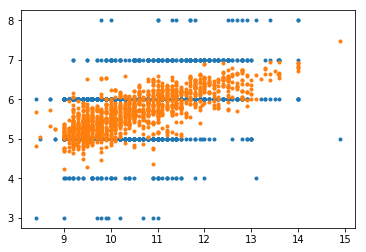

In [30]:
plt.plot(data.alcohol, data.quality, '.')
plt.plot(data.alcohol, f_lin_reg(data, *theta), '.')

## Best subsets

In [31]:
from itertools import combinations

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
def LinRSS(X, y):
    f = LinearRegression().fit(X, y)
    return sum((f.predict(X) - y)**2)

In [34]:
list(combinations([1,2,3], 2))

[(1, 2), (1, 3), (2, 3)]

In [35]:
RSS = {}
for k in range(1, len(variables) + 1):
    RSS[k] = {}
    for subset in combinations(variables, k):
        RSS[k][subset] = LinRSS(data[list(subset)], data.quality)

/Users/dirk/Virtualenvs/std/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


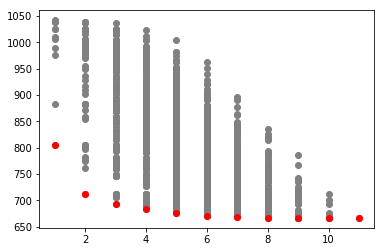

In [36]:
for i in RSS:
    plt.plot([i]*len(RSS[i]), RSS[i].values(), 'o', color='grey')
    plt.plot([i], min(RSS[i].values()), 'o', color='red')

## Ridge Regression

In [37]:
for column in variables:
    mean, std = data[column].mean(), data[column].std()
    data[column] = (data[column] - mean) / std

Define function to calculate

  $$\operatorname{df}(\lambda) =
  \operatorname{tr}\left\{\mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda
  \mathbf{I})^{-1}\mathbf{X}^T\right\}$$


In [38]:
def dof_eff(l):
    X = data[variables].values
    N, p = X.shape
    XTXi = np.linalg.inv(np.dot(X.transpose(), X) + np.identity(p) * l)
    return np.dot(np.dot(X, XTXi), X.transpose()).trace()

Now, we want to calculate which values for $\lambda$ correspond to a set of pre-defined values for degrees of freedom.

In [39]:
from scipy.optimize import minimize_scalar
dof = np.arange(0.5, 10, 0.5)
lambdas = [minimize_scalar(lambda l: (dof_eff(l) - d)**2).x for d in dof]

Define regression function for ridge regresision, fixing $\theta_0 = \hat y$.

In [40]:
theta0 = np.mean(data.quality)

In [41]:
def f_ridge(X, *thetas):
    return theta0 + sum(theta*X[var]
                        for theta, var in zip(thetas, variables))

In [42]:
def ridge(l):
    def D_rige(thetas):
        fev = f_ridge(data, *thetas) - data['quality']
        penalty = [np.sqrt(l)*theta for theta in thetas]
        return np.concatenate((fev, penalty))
    return D_rige

Minimize ridge regressoin equation using least squares.

In [43]:
from scipy.optimize import leastsq

In [44]:
from regression_params import lambdas as lds

In [45]:
MSE = []
thetas = []
for l in lambdas:
    theta = leastsq(ridge(l), [0]*len(variables))[0]
    thetas.append(theta)
    f = f_ridge(data, *theta)
    MSE.append(np.mean((data['quality'] - f)**2))

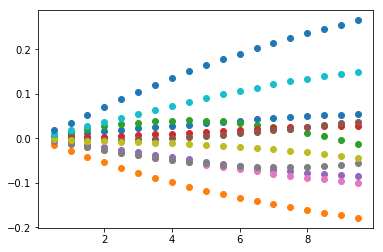

In [46]:
for i in range(len(variables)):
    plt.plot(dof, [theta[i] for theta in thetas], 'o')

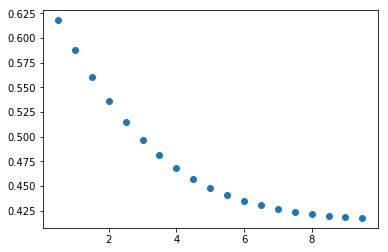

In [47]:
plt.plot(dof, MSE, 'o')